## Import

In [21]:
import h5py
import os
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import (accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, 
                             recall_score, confusion_matrix, precision_recall_curve, auc, 
                             average_precision_score)
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score


from tensorflow.keras.layers import (GlobalAveragePooling2D, BatchNormalization, Input, Conv2D, 
                                     MaxPooling2D, UpSampling2D, Dense, Reshape, Flatten, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


## caricamento dati

In [22]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )


h5_file_path = '../images_by_patient_final.h5'
loaded_class_images=[]

with h5py.File(h5_file_path, 'r') as h5_file:
    loaded_class_images = {key: np.array(h5_file[key]) for key in h5_file.keys()}

loaded_class_images= {int(key.split('_')[1]): images for key, images in loaded_class_images.items()}

print("Lunghezza array immagini: ", len(loaded_class_images))
print("Shape immagini primo paziente: ", loaded_class_images[0].shape)
print("Shape immagini secondo paziente: ", loaded_class_images[1].shape)




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]
Lunghezza array immagini:  129
Shape immagini primo paziente:  (28, 64, 64)
Shape immagini secondo paziente:  (

## encoder

In [23]:

# Load the data
file_path = "../CSV/INCEPTIONV3_ALL_SLICES.csv"
data = pd.read_csv(file_path)

# Filter columns that start with 'original' or 'dentro'
patients = []

for patient_id in loaded_patients:

    # Filter the data for the specific patient
    patient_data = data[data['Patient'] == patient_id]
    
    slices = []
    
    for _, slice_row in patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    patients.append(slices)


## radiomica no wavelet


In [39]:
import pandas as pd
import numpy as np  # Needed for NaN check

# Load the data
file_path = "../CSV/Radiomica_2D.csv"
data = pd.read_csv(file_path)

# Filter columns that start with 'original'
filtered_columns = [col for col in data.columns if col.startswith('original')]

patients = []

for patient_id in loaded_patients:

    # Filter the data for the specific patient
    patient_data = data[data['Paziente'] == patient_id]
    
    slices = []
    
    for _, slice_row in patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row[filtered_columns].tolist()
        
        # Check for NaN values in the slice, and only append if there are no NaNs
        if not any(np.isnan(value) for value in slice_features):
            slices.append(slice_features)
    
    patients.append(slices)

# Optional: Check if all slices with NaN were removed successfully
for i, patient in enumerate(patients):
    for j, slice_features in enumerate(patient):
        assert not any(np.isnan(value) for value in slice_features), f"NaN found in patient {i}, slice {j}"

print("All slices with NaN values have been removed.")


All slices with NaN values have been removed.


## radiomica con wavelet

In [5]:
import pandas as pd
import numpy as np  # Needed for NaN check

# Load the data
file_path = "/Users/alessiamenozzi/Desktop/Radiomica_Wavelet_25D.csv"
data = pd.read_csv(file_path)

# Exclude columns that start with 'diagnostic' and the 'Slice' column
excluded_columns = ['Slice', 'Paziente'] + [col for col in data.columns if col.startswith('diagnostic')]
filtered_columns = [col for col in data.columns if col not in excluded_columns]

patients = []

for patient_id in loaded_patients:

    # Filter the data for the specific patient
    patient_data = data[data['Paziente'] == patient_id]
    
    slices = []
    
    for _, slice_row in patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row[filtered_columns].tolist()
        
        # Check for NaN values in the slice, and only append if there are no NaNs
        if not any(np.isnan(value) for value in slice_features):
            slices.append(slice_features)
    
    patients.append(slices)

# Optional: Check if all slices with NaN were removed successfully
for i, patient in enumerate(patients):
    for j, slice_features in enumerate(patient):
        assert not any(np.isnan(value) for value in slice_features), f"NaN found in patient {i}, slice {j}"

print("All slices with NaN values have been removed.")


All slices with NaN values have been removed.


## funzioni

In [24]:
## funzione per creare array da array di array
def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)
    expanded_labels = []
    expanded_patient_ids = []

    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])
        expanded_labels.extend([labels[i]] * num_images)
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)

    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    return all_features_array, expanded_labels_array, expanded_patient_ids_array


## funzioni per feature correlation
def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    return removed_features


def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    all_images, _, _= continue_array(z_train, y_train)

    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    corr_matrix = df.corr()

    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected

## funzione per rimuovere le features con p_value maggiore della treshold
def select_features_by_p_value(x_train_expanded, y_train_expanded, p_value_threshold=0.05):

    p_values = []
    num_features = x_train_expanded.shape[1]

    for i in range(num_features):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    p_values = np.array(p_values)

    selected_features_indices = np.where(p_values < p_value_threshold)[0]

    sorted_indices = selected_features_indices[np.argsort(p_values[selected_features_indices])]

    x_train_expanded = x_train_expanded[:, sorted_indices]

    return x_train_expanded, sorted_indices



## funzione per rimozione di features specifiche
def remove_features_from_patients(patients, features_to_remove):
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def p_value_feature_selection(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## funzione per lasciare solo le features indicate per array di array
def keep_features_in_patients(patients, features_to_keep):

    feature_indices_to_keep = [int(feature) for feature in features_to_keep]

    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.take(image_features, feature_indices_to_keep, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))

    return final_patients


## funzione per lasciare solo le features indicate per array
def filter_patients_features(filtered_patients, selected_features):

    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected




In [25]:

## funzione per effettuarr majority voting o mean su tutte le slice di un paziente, per passare da una predizione sulla slice
## alla predizione per il paziente
def prob_to_binary(predictions_proba, patient_scores, threshold, mode):
        final_predictionarray=[]          
        if(mode=='MV'): ## majority voting
            for p in predictions_proba:
                test_patient_predictions=[]
                for proba in p:               
                    predictions_binary = 1 if proba[0][1] > threshold else 0
                    test_patient_predictions.append(predictions_binary)
                count_0 = np.sum(np.array(test_patient_predictions)==0) 
                count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
                final_prediction = 0 if count_0 > count_1 else 1
                final_predictionarray.append(final_prediction)
        
        elif (mode=='Mean'): ## mean
            for score in patient_scores:
                predictions_binary = 1 if score > threshold else 0
                final_predictionarray.append(predictions_binary)    
    
        return final_predictionarray


def classification_method(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    if(mode == "Val"):
            selected_features = None 
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded,y_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                    return
                
                features_test = filter_patients_features(features_test, selected_features)
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features) 
        
            smote = SMOTE(random_state=42)

            X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            classifier.fit(X_resampled, y_resampled)

    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
        
    best_f1_score = 0
    best_threshold = None
    #best_precision=0
    #best_recall=0
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    ## viene calcolata la threshold che porta a un f1 migliore e effettuata la prediction con quella
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                #best_precision = precision_score(y_test, binary_predictions)
                #best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore che viene passata dal validation
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        #best_precision = precision_score(y_test, best_prediction)
        #best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)

    #precision, recall, _ = precision_recall_curve(y_test, patient_scores) ## utili per ricostruire grafici
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)

    # Calcola la balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, best_prediction)

    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, conf, test_accuracy, pr_auc, roc_auc, best_threshold, number_features, selected_features, bal_acc

###################################################################################################################################################################

## questa funzione è da utilizzare quando si fa il training sul test e gli vengono già passate le features, quindi non viene effettuata feature selection
## ma solo allenamento del classificatore

def classification_method_test_intero(classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, thresholds, mode):
       
    smote = SMOTE(random_state=42)
    #adasyn = ADASYN(random_state=42)


    X_resampled, y_resampled = smote.fit_resample(x_train_expanded, y_train_expanded)
    #X_resampled, y_resampled = adasyn.fit_resample(x_train_expanded, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)


    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità


    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
 
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    best_threshold = thresholds
    best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, mode)
    best_f1_score = f1_score(y_test, best_prediction)
    best_precision = precision_score(y_test, best_prediction)
    best_recall = recall_score(y_test, best_prediction)

    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy


def classifierinitialization(classifier):
    if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi

## split

In [26]:

# patients_train contiene il nome dei pazienti (5,12 etc)
# y_train contiene le labels
# features_train contiene array di array dove ogni paziente ha varie immagini rappresentate da n features

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.3, shuffle=False, random_state=1)
patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=3)
#patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.15, shuffle=False, random_state=1)

print("Number of train patients: ", len(features_train))
print("Number of test patients: ", len(features_test))
print("Number of val patients: ", len(features_val))

print("Number of features for every image: ", len(features_train[0][0]) )


Number of train patients:  63
Number of test patients:  39
Number of val patients:  27
Number of features for every image:  2050


In [46]:
alpha_values = (np.linspace(0.25, 1, 30)).tolist() ## per vgg
alpha_values = (np.linspace(0.01, 0.6, 30)).tolist()  ## per resnet
alpha_values = (np.linspace(0.001, 0.2, 30)).tolist() ## per inception

alpha_values = (np.linspace(0.001, 0.02, 20)).tolist() + (np.linspace(0.022, 0.2, 10)).tolist()## per inception
#alpha_values= (np.linspace(0.001, 0.019, 19)).tolist() + (np.linspace(0.20, 1, 9)).tolist() ## range per radiomica wavelet

alpha_values = [round(alpha, 4) for alpha in alpha_values]

selectors=['mrmr','rf', 'logistic', 'lasso']
#selectors=[ 'mrmr','rf', 'lasso', 'logistic']
classifiers=['RandomForest', 'Logistic', 'XgBoost', 'MLP', 'SVM', 'ensemble']
modes=['Mean', 'MV']


In [45]:
print(alpha_values)

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.022, 0.0418, 0.0616, 0.0813, 0.1011, 0.1209, 0.1407, 0.1604, 0.1802, 0.2]


In [29]:
starting_features = len(features_train[0][0])
features=perform_correlation(features_train, y_train, starting_features, 0.8)

final_patients_train=remove_features_from_patients(features_train, features)
final_patients_test=remove_features_from_patients(features_test, features)
final_patients_val=remove_features_from_patients(features_val, features)
final_patients_train1=remove_features_from_patients(features_train1, features)
print(final_patients_train1[0].shape)
x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)
x_train_expanded, sf= select_features_by_p_value(x_train_expanded, y_train_expanded, 0.01)
print("x_train_expanded", x_train_expanded.shape)


final_patients_test=keep_features_in_patients(final_patients_test, sf)
final_patients_val=keep_features_in_patients(final_patients_val, sf)
final_patients_train1=keep_features_in_patients(final_patients_train1, sf)
print("final_patients_val", final_patients_val[0].shape)
print("final_patients_test", final_patients_test[0].shape)
print("final_patients_train1", final_patients_train1[0].shape)
print(f"Scelte {len(sf)} features\n")


x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
print("x_train_expanded1", x_train_expanded1.shape)

(41, 1994)
x_train_expanded (2698, 935)
final_patients_val (41, 935)
final_patients_test (43, 935)
final_patients_train1 (41, 935)
Scelte 935 features

x_train_expanded1 (3724, 935)


## Loop results_val e test

In [47]:
template_dict = {
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'mode': None,
                'balanced accuracy': None
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict.copy() for _ in range(900000)]
results_val.append(template_dict.copy())

results_test = [template_dict.copy() for _ in range(900000)]
results_test.append(template_dict.copy())

k=0
for mode in modes:
     print("Starting with mode:", mode)
     for classifier in classifiers:
          print("Starting with classifier:", classifier)
          for selector in selectors: 
               print("Doing with selector:", selector)
               if selector == 'lasso':
                         for alpha in alpha_values:
                              print("sto facendo alpha:",alpha)

                              classi=classifierinitialization(classifier)
                                   
                              best_f1_score, conf, test_accuracy, pr_auc, roc_auc, bt, number_features, selected_features, bal_acc= classification_method(
                                   selector, alpha, classi, x_train_expanded, y_train_expanded, 
                                   patients_val, y_val, final_patients_val, 0, mode, thresholds=0.5
                              )

                              if(best_f1_score==0 and bal_acc==0):
                                   continue
                              
                              print(f"per {alpha} sceglie {number_features}")
                              results_val[k]['classifier']=classifier
                              results_val[k]['selector']=selector
                              results_val[k]['alpha']= alpha
                              results_val[k]['num_features']= number_features
                              results_val[k]['selected_features']=selected_features
                              results_val[k]['pr_auc']=pr_auc
                              results_val[k]['roc_auc']=roc_auc
                              results_val[k]['f1']=best_f1_score
                              results_val[k]['accuracy']= test_accuracy
                              results_val[k]['confusion_matrix']= conf
                              results_val[k]['mode']= mode
                              results_val[k]['balanced accuracy']= bal_acc

                              classi=classifierinitialization(classifier)

                              best_f1_score, conf, test_accuracy, pr_auc, roc_auc, bt, number_features, selected_features, bal_acc= classification_method(
                                   selector, alpha, classi, x_train_expanded, y_train_expanded, 
                                   patients_test, y_test, final_patients_test, 0, mode, thresholds=0.5
                              )

                              if(best_f1_score==0 and bal_acc==0):
                                   continue
                              
                              results_test[k]['classifier']=classifier
                              results_test[k]['selector']=selector
                              results_test[k]['alpha']= alpha
                              results_test[k]['num_features']= number_features
                              results_test[k]['selected_features']=selected_features
                              results_test[k]['pr_auc']=pr_auc
                              results_test[k]['roc_auc']=roc_auc
                              results_test[k]['f1']=best_f1_score
                              results_test[k]['accuracy']= test_accuracy
                              results_test[k]['confusion_matrix']= conf
                              results_test[k]['mode']= mode
                              results_test[k]['balanced accuracy']= bal_acc


                              k=k+1
                              

               else:
                              #limit=len(x_train_expanded[0])+1
                              limit=30
                              for t in range(2, limit):
                                   print("sto facendo features:",t)
                                        
                                   classi=classifierinitialization(classifier)
                                        
                                   best_f1_score,conf, test_accuracy,pr_auc, roc_auc, bt, _, selected_features, bal_acc= classification_method(
                                        selector, 0, classi, x_train_expanded, y_train_expanded, 
                                        patients_val, y_val, final_patients_val, t, mode, thresholds=0.5
                                   )
                                   if(best_f1_score==0 and bal_acc==0):
                                        continue
                                   results_val[k]['classifier']=classifier
                                   results_val[k]['selector']=selector
                                   results_val[k]['alpha']= 0
                                   results_val[k]['num_features']= t
                                   results_val[k]['selected_features']=selected_features
                                   results_val[k]['pr_auc']=pr_auc
                                   results_val[k]['roc_auc']=roc_auc
                                   results_val[k]['f1']=best_f1_score
                                   results_val[k]['accuracy']= test_accuracy
                                   results_val[k]['confusion_matrix']= conf
                                   results_val[k]['mode']= mode
                                   results_val[k]['balanced accuracy']= bal_acc

                                   
                                   classi=classifierinitialization(classifier)

                                   best_f1_score,conf, test_accuracy, pr_auc, roc_auc, bt, number_features, selected_features, bal_acc= classification_method(
                                        selector, 0, classi, x_train_expanded, y_train_expanded, 
                                        patients_test, y_test, final_patients_test, t, mode, thresholds=0.5
                                   )

                                   if(best_f1_score==0 and bal_acc==0):
                                        continue
                                   
                                   results_test[k]['classifier']= classifier
                                   results_test[k]['selector']=selector
                                   results_test[k]['alpha']= 0
                                   results_test[k]['num_features']= t
                                   results_test[k]['selected_features']=selected_features
                                   results_test[k]['pr_auc']=pr_auc
                                   results_test[k]['roc_auc']=roc_auc
                                   results_test[k]['f1']=best_f1_score
                                   results_test[k]['accuracy']= test_accuracy
                                   results_test[k]['confusion_matrix']= conf
                                   results_test[k]['mode']= mode
                                   results_test[k]['balanced accuracy']= bal_acc

                                   k=k+1

          
                    

per 0.007 sceglie 306


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.008


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.008 sceglie 265


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.009


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.009 sceglie 247


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.01 sceglie 222


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.011


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.011 sceglie 202


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.012
per 0.012 sceglie 190
sto facendo alpha: 0.013
per 0.013 sceglie 164
sto facendo alpha: 0.014
per 0.014 sceglie 152
sto facendo alpha: 0.015
per 0.015 sceglie 136
sto facendo alpha: 0.016
per 0.016 sceglie 128
sto facendo alpha: 0.017
per 0.017 sceglie 115
sto facendo alpha: 0.018
per 0.018 sceglie 107
sto facendo alpha: 0.019
per 0.019 sceglie 99
sto facendo alpha: 0.02
per 0.02 sceglie 95
sto facendo alpha: 0.022
per 0.022 sceglie 85
sto facendo alpha: 0.0418
per 0.0418 sceglie 39
sto facendo alpha: 0.0616
per 0.0616 sceglie 24
sto facendo alpha: 0.0813
per 0.0813 sceglie 15
sto facendo alpha: 0.1011
per 0.1011 sceglie 10
sto facendo alpha: 0.1209
per 0.1209 sceglie 5
sto facendo alpha: 0.1407
per 0.1407 sceglie 4
sto facendo alpha: 0.1604
per 0.1604 sceglie 3
sto facendo alpha: 0.1802
per 0.1802 sceglie 3
sto facendo alpha: 0.2
per 0.2 sceglie 2
Starting with mode: MV
Starting with classifier: RandomForest
Doing with selector: mrmr
sto facendo features: 2
st

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.001 sceglie 748


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.002


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.002 sceglie 619


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.003


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.003 sceglie 531


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.004


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.004 sceglie 464


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.005


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.005 sceglie 398


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.006


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.006 sceglie 349


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.007


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.007 sceglie 306


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.008


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.008 sceglie 265


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.009


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.009 sceglie 247


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.01 sceglie 222


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.011


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.011 sceglie 202


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.012
per 0.012 sceglie 190
sto facendo alpha: 0.013
per 0.013 sceglie 164
sto facendo alpha: 0.014
per 0.014 sceglie 152
sto facendo alpha: 0.015
per 0.015 sceglie 136
sto facendo alpha: 0.016
per 0.016 sceglie 128
sto facendo alpha: 0.017
per 0.017 sceglie 115
sto facendo alpha: 0.018
per 0.018 sceglie 107
sto facendo alpha: 0.019
per 0.019 sceglie 99
sto facendo alpha: 0.02
per 0.02 sceglie 95
sto facendo alpha: 0.022
per 0.022 sceglie 85
sto facendo alpha: 0.0418
per 0.0418 sceglie 39
sto facendo alpha: 0.0616
per 0.0616 sceglie 24
sto facendo alpha: 0.0813
per 0.0813 sceglie 15
sto facendo alpha: 0.1011
per 0.1011 sceglie 10
sto facendo alpha: 0.1209
per 0.1209 sceglie 5
sto facendo alpha: 0.1407
per 0.1407 sceglie 4
sto facendo alpha: 0.1604
per 0.1604 sceglie 3
sto facendo alpha: 0.1802
per 0.1802 sceglie 3
sto facendo alpha: 0.2
per 0.2 sceglie 2
Starting with classifier: Logistic
Doing with selector: mrmr
sto facendo features: 2
sto facendo features: 3
sto f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.001 sceglie 748


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.002


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.002 sceglie 619


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.003


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.003 sceglie 531


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.004


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.004 sceglie 464


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.005


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.005 sceglie 398


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.006


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.006 sceglie 349


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.007


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.007 sceglie 306


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.008


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.008 sceglie 265


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.009


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.009 sceglie 247


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.01 sceglie 222


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.011


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.011 sceglie 202


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.012
per 0.012 sceglie 190
sto facendo alpha: 0.013
per 0.013 sceglie 164
sto facendo alpha: 0.014
per 0.014 sceglie 152
sto facendo alpha: 0.015
per 0.015 sceglie 136
sto facendo alpha: 0.016
per 0.016 sceglie 128
sto facendo alpha: 0.017
per 0.017 sceglie 115
sto facendo alpha: 0.018
per 0.018 sceglie 107
sto facendo alpha: 0.019
per 0.019 sceglie 99
sto facendo alpha: 0.02
per 0.02 sceglie 95
sto facendo alpha: 0.022
per 0.022 sceglie 85
sto facendo alpha: 0.0418
per 0.0418 sceglie 39
sto facendo alpha: 0.0616
per 0.0616 sceglie 24
sto facendo alpha: 0.0813
per 0.0813 sceglie 15
sto facendo alpha: 0.1011
per 0.1011 sceglie 10
sto facendo alpha: 0.1209
per 0.1209 sceglie 5
sto facendo alpha: 0.1407
per 0.1407 sceglie 4
sto facendo alpha: 0.1604
per 0.1604 sceglie 3
sto facendo alpha: 0.1802
per 0.1802 sceglie 3
sto facendo alpha: 0.2
per 0.2 sceglie 2
Starting with classifier: XgBoost
Doing with selector: mrmr
sto facendo features: 2
sto facendo features: 3
sto fa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.001 sceglie 748


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.002


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.002 sceglie 619


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.003


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.003 sceglie 531


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.004


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.004 sceglie 464


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.005


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.005 sceglie 398


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.006


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.006 sceglie 349


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.007


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.007 sceglie 306


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.008


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.008 sceglie 265


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.009


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.009 sceglie 247


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.01 sceglie 222


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.011


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.011 sceglie 202


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.012
per 0.012 sceglie 190
sto facendo alpha: 0.013
per 0.013 sceglie 164
sto facendo alpha: 0.014
per 0.014 sceglie 152
sto facendo alpha: 0.015
per 0.015 sceglie 136
sto facendo alpha: 0.016
per 0.016 sceglie 128
sto facendo alpha: 0.017
per 0.017 sceglie 115
sto facendo alpha: 0.018
per 0.018 sceglie 107
sto facendo alpha: 0.019
per 0.019 sceglie 99
sto facendo alpha: 0.02
per 0.02 sceglie 95
sto facendo alpha: 0.022
per 0.022 sceglie 85
sto facendo alpha: 0.0418
per 0.0418 sceglie 39
sto facendo alpha: 0.0616
per 0.0616 sceglie 24
sto facendo alpha: 0.0813
per 0.0813 sceglie 15
sto facendo alpha: 0.1011
per 0.1011 sceglie 10
sto facendo alpha: 0.1209
per 0.1209 sceglie 5
sto facendo alpha: 0.1407
per 0.1407 sceglie 4
sto facendo alpha: 0.1604
per 0.1604 sceglie 3
sto facendo alpha: 0.1802
per 0.1802 sceglie 3
sto facendo alpha: 0.2
per 0.2 sceglie 2
Starting with classifier: MLP
Doing with selector: mrmr
sto facendo features: 2
sto facendo features: 3
sto facend

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.001 sceglie 748


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.002


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.002 sceglie 619


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.003


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.003 sceglie 531


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.004


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.004 sceglie 464


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.005


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.005 sceglie 398


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.006


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.006 sceglie 349


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.007


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.007 sceglie 306


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.008


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.008 sceglie 265


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.009


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.009 sceglie 247


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.01 sceglie 222


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.011


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.011 sceglie 202


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.012
per 0.012 sceglie 190
sto facendo alpha: 0.013
per 0.013 sceglie 164
sto facendo alpha: 0.014
per 0.014 sceglie 152
sto facendo alpha: 0.015
per 0.015 sceglie 136
sto facendo alpha: 0.016
per 0.016 sceglie 128
sto facendo alpha: 0.017
per 0.017 sceglie 115
sto facendo alpha: 0.018
per 0.018 sceglie 107
sto facendo alpha: 0.019
per 0.019 sceglie 99
sto facendo alpha: 0.02
per 0.02 sceglie 95
sto facendo alpha: 0.022
per 0.022 sceglie 85
sto facendo alpha: 0.0418
per 0.0418 sceglie 39
sto facendo alpha: 0.0616
per 0.0616 sceglie 24
sto facendo alpha: 0.0813
per 0.0813 sceglie 15
sto facendo alpha: 0.1011
per 0.1011 sceglie 10
sto facendo alpha: 0.1209
per 0.1209 sceglie 5
sto facendo alpha: 0.1407
per 0.1407 sceglie 4
sto facendo alpha: 0.1604
per 0.1604 sceglie 3
sto facendo alpha: 0.1802
per 0.1802 sceglie 3
sto facendo alpha: 0.2
per 0.2 sceglie 2
Starting with classifier: SVM
Doing with selector: mrmr
sto facendo features: 2
sto facendo features: 3
sto facend

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.001 sceglie 748


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.002


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.002 sceglie 619


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.003


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.003 sceglie 531


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.004


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.004 sceglie 464


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.005


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.005 sceglie 398


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.006


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.006 sceglie 349


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.007


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.007 sceglie 306


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.008


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.008 sceglie 265


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.009


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.009 sceglie 247


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.01 sceglie 222


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.011


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.011 sceglie 202


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.012
per 0.012 sceglie 190
sto facendo alpha: 0.013
per 0.013 sceglie 164
sto facendo alpha: 0.014
per 0.014 sceglie 152
sto facendo alpha: 0.015
per 0.015 sceglie 136
sto facendo alpha: 0.016
per 0.016 sceglie 128
sto facendo alpha: 0.017
per 0.017 sceglie 115
sto facendo alpha: 0.018
per 0.018 sceglie 107
sto facendo alpha: 0.019
per 0.019 sceglie 99
sto facendo alpha: 0.02
per 0.02 sceglie 95
sto facendo alpha: 0.022
per 0.022 sceglie 85
sto facendo alpha: 0.0418
per 0.0418 sceglie 39
sto facendo alpha: 0.0616
per 0.0616 sceglie 24
sto facendo alpha: 0.0813
per 0.0813 sceglie 15
sto facendo alpha: 0.1011
per 0.1011 sceglie 10
sto facendo alpha: 0.1209
per 0.1209 sceglie 5
sto facendo alpha: 0.1407
per 0.1407 sceglie 4
sto facendo alpha: 0.1604
per 0.1604 sceglie 3
sto facendo alpha: 0.1802
per 0.1802 sceglie 3
sto facendo alpha: 0.2
per 0.2 sceglie 2
Starting with classifier: ensemble
Doing with selector: mrmr
sto facendo features: 2
sto facendo features: 3
sto f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.001 sceglie 748


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.002


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.002 sceglie 619


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.470e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.003


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.003 sceglie 531


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.081e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.004


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.004 sceglie 464


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.005


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.005 sceglie 398


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.006


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.006 sceglie 349


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.007


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.007 sceglie 306


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.008


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.008 sceglie 265


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.009


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.009 sceglie 247


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.892e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.01 sceglie 222


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e-01, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.011


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


per 0.011 sceglie 202


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.752e-02, tolerance: 6.687e-02
  model = cd_fast.enet_coordinate_descent(


sto facendo alpha: 0.012
per 0.012 sceglie 190
sto facendo alpha: 0.013
per 0.013 sceglie 164
sto facendo alpha: 0.014
per 0.014 sceglie 152
sto facendo alpha: 0.015
per 0.015 sceglie 136
sto facendo alpha: 0.016
per 0.016 sceglie 128
sto facendo alpha: 0.017
per 0.017 sceglie 115
sto facendo alpha: 0.018
per 0.018 sceglie 107
sto facendo alpha: 0.019
per 0.019 sceglie 99
sto facendo alpha: 0.02
per 0.02 sceglie 95
sto facendo alpha: 0.022
per 0.022 sceglie 85
sto facendo alpha: 0.0418
per 0.0418 sceglie 39
sto facendo alpha: 0.0616
per 0.0616 sceglie 24
sto facendo alpha: 0.0813
per 0.0813 sceglie 15
sto facendo alpha: 0.1011
per 0.1011 sceglie 10
sto facendo alpha: 0.1209
per 0.1209 sceglie 5
sto facendo alpha: 0.1407
per 0.1407 sceglie 4
sto facendo alpha: 0.1604
per 0.1604 sceglie 3
sto facendo alpha: 0.1802
per 0.1802 sceglie 3
sto facendo alpha: 0.2
per 0.2 sceglie 2


## dizionari

### salvo

In [48]:
import pickle

with open('/Users/alessiamenozzi/Desktop/results 2.5 DEFINITIVI/Inception/results_test_Inception_2.5', 'wb') as pickle_file:
    pickle.dump(results_test, pickle_file)

with open('/Users/alessiamenozzi/Desktop/results 2.5 DEFINITIVI/Inception/results_val_Inception_2.5', 'wb') as pickle_file:
    pickle.dump(results_val, pickle_file)

### apro

In [92]:
import pickle

with open("/Users/alessiamenozzi/Desktop/results_test_VGG_2.5", 'rb') as file:
    results_test = pickle.load(file)

with open("/Users/alessiamenozzi/Desktop/results_val_VGG_2.5", 'rb') as file:
    results_val = pickle.load(file)

## printa i risultati di una configurazipne specifica

In [134]:
import pandas as pd

def print_results_for_val_and_test(mode, classifier, selector, num_features=None, alpha=None):
    # Convert the lists of dictionaries to DataFrames
    df_results_val = pd.DataFrame(results_val)
    df_results_test = pd.DataFrame(results_test)

    # Search for the matching validation result
    if selector == 'lasso' and alpha is not None:
        val_match = df_results_val[
            (df_results_val['classifier'] == classifier) &
            (df_results_val['selector'] == selector) &
            (df_results_val['alpha'] == alpha) &
            (df_results_val['mode'] == mode)
        ]
    else:
        val_match = df_results_val[
            (df_results_val['classifier'] == classifier) &
            (df_results_val['selector'] == selector) &
            (df_results_val['num_features'] == num_features) &
            (df_results_val['mode'] == mode)
        ]

    # Search for the matching test result
    if selector == 'lasso' and alpha is not None:
        test_match = df_results_test[
            (df_results_test['classifier'] == classifier) &
            (df_results_test['selector'] == selector) &
            (df_results_test['alpha'] == alpha) &
            (df_results_test['mode'] == mode)
        ]
    else:
        test_match = df_results_test[
            (df_results_test['classifier'] == classifier) &
            (df_results_test['selector'] == selector) &
            (df_results_test['num_features'] == num_features) &
            (df_results_test['mode'] == mode)
        ]

    # Print Validation Results
    if not val_match.empty:
        val_row = val_match.iloc[0]  # Get the first match if there are multiple
        print("Validation Metrics:")
        print(f"Classifier: {val_row['classifier']}")
        print(f"Selector: {val_row['selector']}")
        if selector == 'lasso':
            print(f"Alpha: {val_row['alpha']}")
        else:
            print(f"Num Features: {val_row['num_features']}")
        print(f"Mode: {val_row['mode']}")
        print(f"ROC AUC (Validation): {val_row['roc_auc']:.4f}")
        print(f"PR AUC (Validation): {val_row['pr_auc']:.4f}")
        print(f"F1 Score (Validation): {val_row['f1']:.4f}")
        print(f"Accuracy (Validation): {val_row['accuracy']:.4f}")
        print(f"Confusion Matrix (Validation): \n{val_row['confusion_matrix']}")
        print("="*50)
    else:
        print("No matching validation result found.")

    # Print Test Results
    if not test_match.empty:
        test_row = test_match.iloc[0]  # Get the first match if there are multiple
        print("Test Metrics:")
        print(f"Classifier: {test_row['classifier']}")
        print(f"Selector: {test_row['selector']}")
        if selector == 'lasso':
            print(f"Alpha: {test_row['alpha']}")
        else:
            print(f"Num Features: {test_row['num_features']}")
        print(f"Mode: {test_row['mode']}")
        print(f"ROC AUC (Test): {test_row['roc_auc']:.4f}")
        print(f"PR AUC (Test): {test_row['pr_auc']:.4f}")
        print(f"F1 Score (Test): {test_row['f1']:.4f}")
        print(f"Accuracy (Test): {test_row['accuracy']:.4f}")
        print(f"Confusion Matrix (Test): \n{test_row['confusion_matrix']}")
        print("="*50)
    else:
        print("No matching test result found.")

# Example usage:
print_results_for_val_and_test(
    mode='Mean', 
    classifier='XgBoost', 
    selector='logistic',
    num_features=17
)


Validation Metrics:
Classifier: XgBoost
Selector: logistic
Num Features: 17.0
Mode: Mean
ROC AUC (Validation): 0.5889
PR AUC (Validation): 0.5338
F1 Score (Validation): 0.6400
Accuracy (Validation): 0.6667
Confusion Matrix (Validation): 
[[10  5]
 [ 4  8]]
Test Metrics:
Classifier: XgBoost
Selector: logistic
Num Features: 17.0
Mode: Mean
ROC AUC (Test): 0.7160
PR AUC (Test): 0.5833
F1 Score (Test): 0.6364
Accuracy (Test): 0.7949
Confusion Matrix (Test): 
[[24  3]
 [ 5  7]]


## Plot roc / f1 di val e test per una configurazione specifica

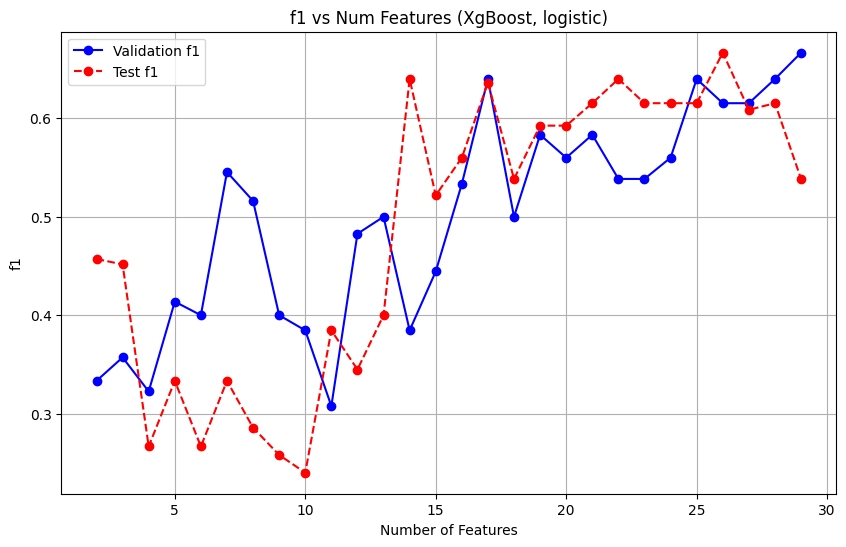

In [133]:
METRICA='f1'
def plot_f1_vs_num_features(classifier, selector, mode, metrica):
    """
    Plot F1 score vs num_features for both validation and test sets.
    """
    # Extract num_features and F1 score from validation results
    val_num_features = []
    val_f1_scores = []
    
    for result in results_val:
        if (result['classifier'] == classifier and
            result['selector'] == selector and
            result['mode']== mode):
            if result['num_features'] is not None:
                val_num_features.append(result['num_features'])
                val_f1_scores.append(result[metrica])

    # Extract num_features and F1 score from test results
    test_num_features = []
    test_f1_scores = []
    
    for result in results_test:
        if (result['classifier'] == classifier and
            result['selector'] == selector and 
            result['mode']== mode):
            if result['num_features'] is not None:
                test_num_features.append(result['num_features'])
                test_f1_scores.append(result[metrica])

    # Plot the F1 score vs num_features for both validation and test
    plt.figure(figsize=(10, 6))
    
    plt.plot(val_num_features, val_f1_scores, label=f'Validation {metrica}', marker='o', linestyle='-', color='b')
    plt.plot(test_num_features, test_f1_scores, label=f'Test {metrica}', marker='o', linestyle='--', color='r')
    
    plt.title(f"{metrica} vs Num Features ({classifier}, {selector})")
    plt.xlabel('Number of Features')
    plt.ylabel(f'{metrica}')
    plt.legend()
    
    plt.grid(True)
    plt.show()

# Example usage:
plot_f1_vs_num_features(
    mode='Mean', 
    classifier='XgBoost', 
    selector='logistic',
    metrica=METRICA
)


## sorting results per validation

In [54]:
import statistics

# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value', 'lasso']
modes=['Mean', 'MV']
#num_features_range = list(range(2, len(X_train_reduced[0]) + 1))
num_features_range=list(range(2,30))

grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features)
for mode in modes:
    for classifier in classifiers:
        print(f"sto iniziando classifier {classifier}")
        for selector in selectors:
            print(f"sto iniziando selector {selector}")

            if (selector)=='lasso':
                for alpha in alpha_values:
                    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha and res['mode']=='mode']

                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]
                        roc_values = [res['roc_auc'] for res in filtered_results]
                        
                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)
                        
                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                        std_roc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0
                        
                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results[(classifier, selector, alpha)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy,
                            'std_roc_auc':std_roc,
                            'avg_roc_auc': avg_roc,

                        }
            
            else:
                for num_features in num_features_range:
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['mode']==mode]
                    
                    if filtered_results:
                        print("found")
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]
                        roc_values = [res['roc_auc'] for res in filtered_results]
                        
                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)
                        
                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                        std_roc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0
                        
                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results[(classifier, selector, num_features, mode)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy,
                            'std_roc_auc':std_roc,
                            'avg_roc_auc': avg_roc
                        }


    # Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
    sorted_results_val = sorted(grid_results.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)

In [ ]:
import pickle

with open('/Users/alessiamenozzi/Desktop/sorted_results_test_VGG_max30_0.3', 'wb') as pickle_file:
    pickle.dump(sorted_results_test, pickle_file)

In [45]:
with open("/Users/alessiamenozzi/Desktop/sorted_results_test_VGG_max30_0.3", 'rb') as file:
    sorted_results_test = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alessiamenozzi/Desktop/sorted_results_test_VGG_max30_0.3'

In [49]:
n=20
best_3_combinations = sorted_results_val[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")
    print(f"Mode : {params[3]}")

    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})"
          f"ROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression(random_state=42)
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    best_case=None

    for res in results_test:
        if(params[1]=='lasso'):
            if(res['classifier']==params[0] and res['selector']==params[1] and res['mode']==params[3] and res['alpha']==params[2]):
                best_case=res

        else:
            if(res['classifier']==params[0] and res['selector']==params[1] and res['mode']==params[3] and res['num_features']==params[2]):
                best_case=res

    if (best_case!=None):
        print("Metrics from best_case ON THE TEST SET:")
        if (params[1]=='lasso'):
                print(f"Alpha: {best_case['alpha']}")
        print(f"Number of Features: {best_case['num_features']}")
        print(f"Selected Features: {best_case['selected_features']}")
        print(f"Precision-Recall AUC: {best_case['pr_auc']}")
        print(f"Best Precision: {best_case['best_precision']}")
        print(f"Best Recall: {best_case['best_recall']}")
        print(f"ROC AUC: {best_case['roc_auc']}")
        print(f"F1 Score: {best_case['f1']}")
        print(f"Accuracy: {best_case['accuracy']}")
        print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")
        print(f"Best Threshold: {best_case['best_threshold']}")

[]
Migliori 20 combinazioni di parametri:


## grafici

### grafico che mostra per ogni classifier e selector e per i due mean, il risultato che ottiene la roc_auc migliore

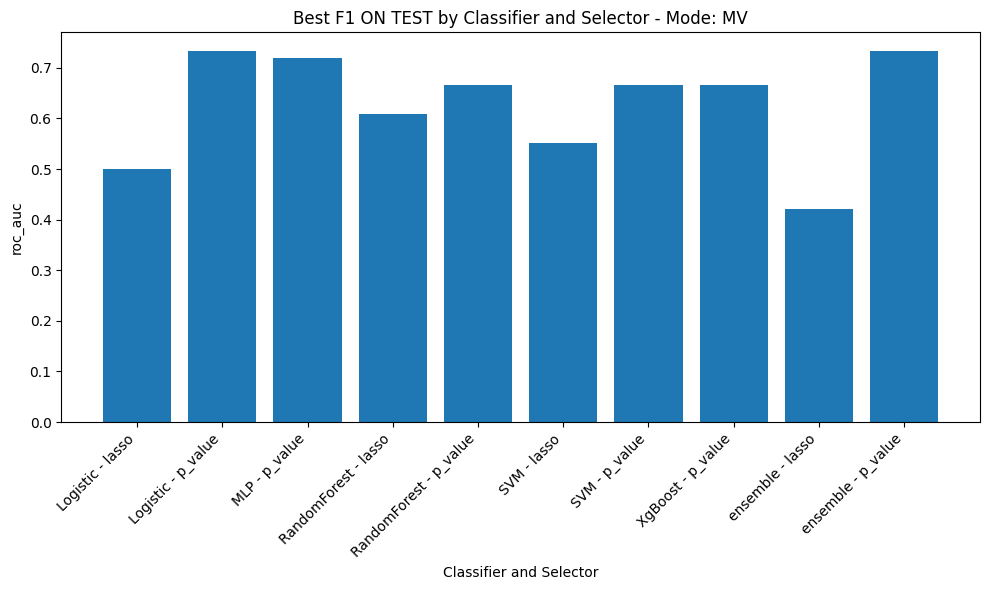

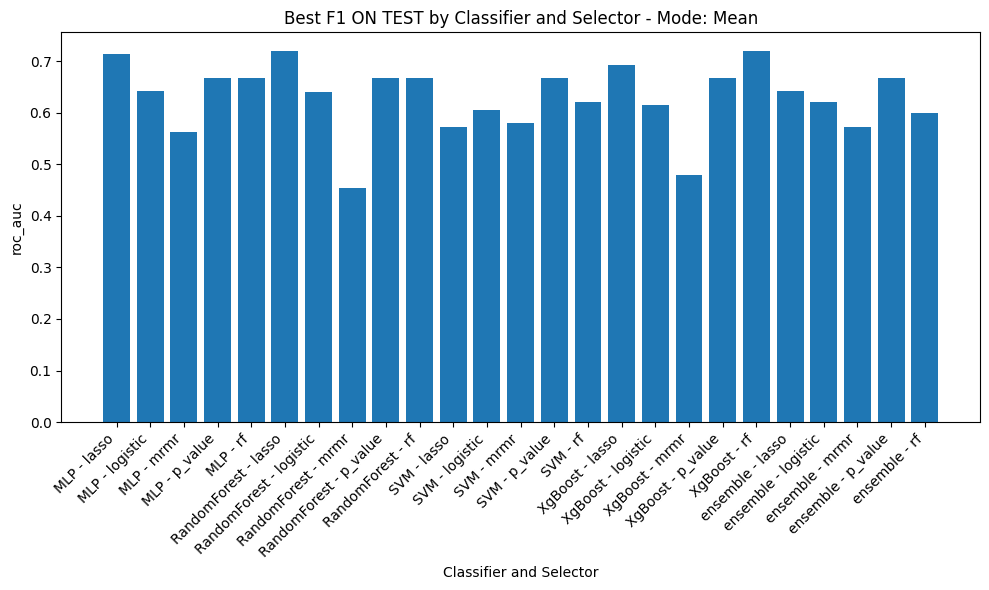

In [21]:

# Convert to DataFrame
df = pd.DataFrame(results_test)

# Assuming df is already loaded with your results

# Filter by mode and selector 'mrmr', and select the best f1 for each classifier and selector
def get_best_results_by_mode(mode, df):
    # Filter by mode and selector = 'mrmr'
    #mode_df = df[(df['mode'] == mode) & (df['selector'] == 'mrmr')]
    mode_df = df[(df['mode'] == mode)]
    best_results = mode_df.loc[mode_df.groupby(['classifier', 'selector'])['f1'].idxmax()]
    return best_results

# Get the best results for both modes 'MV' and 'Mean', and only where selector='mrmr'
best_results_mv = get_best_results_by_mode('MV', df)
best_results_mean = get_best_results_by_mode('Mean', df)

# Create a plot for each mode
def plot_best_results(best_results, mode):
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = []
    f1_values = []
    features_or_alpha_values = []
    
    for index, row in best_results.iterrows():
        label = f"{row['classifier']} - {row['selector']}"
        features_or_alpha = row['alpha'] if row['selector'] == 'lasso' else row['num_features']
        labels.append(label)
        f1_values.append(row['f1'])
        features_or_alpha_values.append(features_or_alpha)
    
    ax.bar(labels, f1_values)
    ax.set_title(f"Best F1 ON TEST by Classifier and Selector - Mode: {mode}")
    ax.set_xlabel("Classifier and Selector")
    ax.set_ylabel("roc_auc")
    
    # Annotate the bars with the number of features/alpha
    #for i, val in enumerate(f1_values):
        #ax.text(i, val + 0.01, f"features/alpha: {features_or_alpha_values[i]}", ha='center', va='bottom')

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot for MV mode with selector 'mrmr'
plot_best_results(best_results_mv, 'MV')

# Plot for Mean mode with selector 'mrmr'
plot_best_results(best_results_mean, 'Mean')



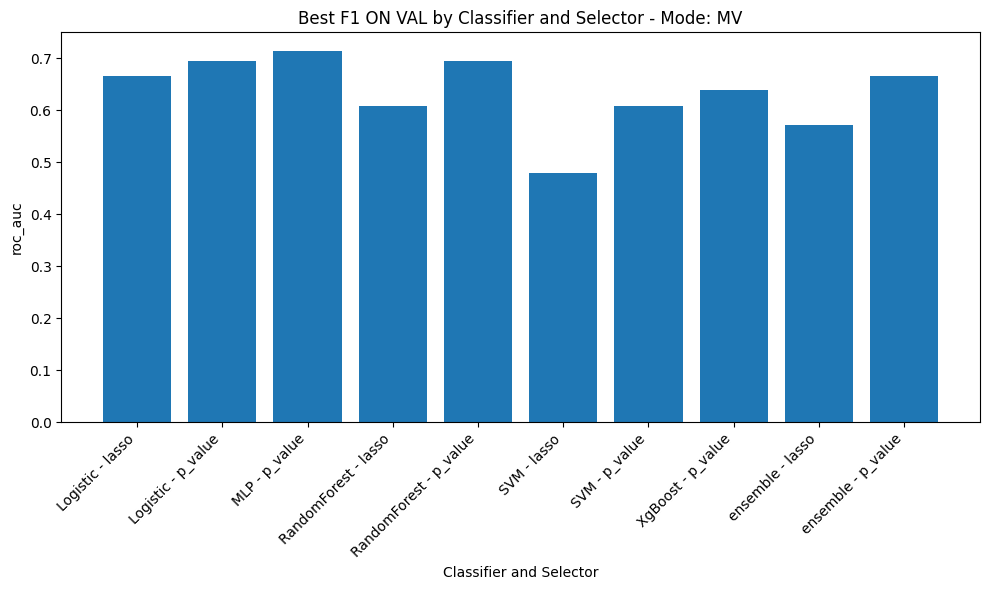

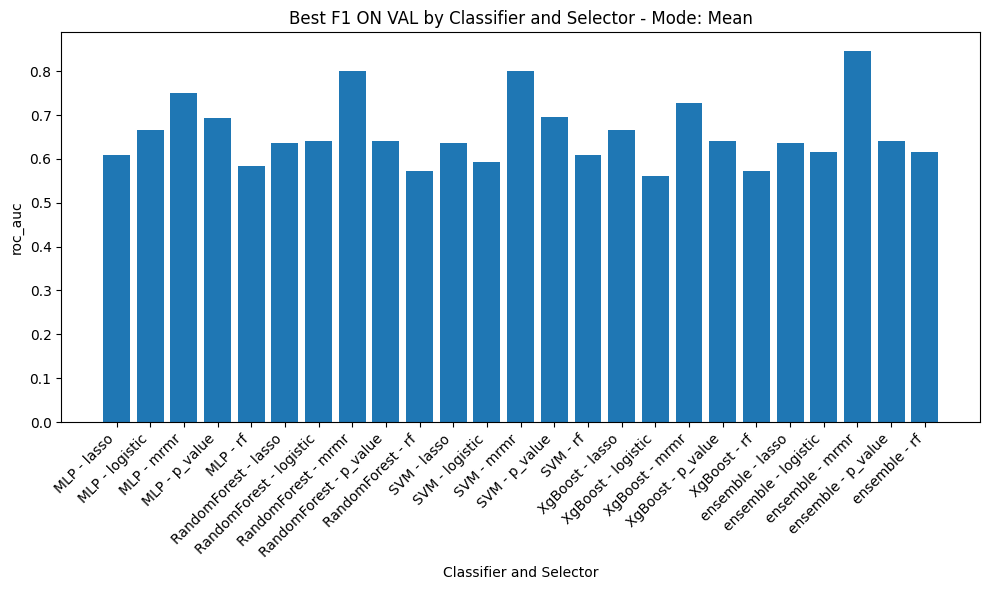

In [22]:

# Convert to DataFrame
df = pd.DataFrame(results_val)

# Assuming df is already loaded with your results

# Filter by mode and selector 'mrmr', and select the best f1 for each classifier and selector
def get_best_results_by_mode(mode, df):
    # Filter by mode and selector = 'mrmr'
    #mode_df = df[(df['mode'] == mode) & (df['selector'] == 'mrmr')]
    mode_df = df[(df['mode'] == mode)]
    best_results = mode_df.loc[mode_df.groupby(['classifier', 'selector'])['f1'].idxmax()]
    return best_results

# Get the best results for both modes 'MV' and 'Mean', and only where selector='mrmr'
best_results_mv = get_best_results_by_mode('MV', df)
best_results_mean = get_best_results_by_mode('Mean', df)

# Create a plot for each mode
def plot_best_results(best_results, mode):
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = []
    f1_values = []
    features_or_alpha_values = []
    
    for index, row in best_results.iterrows():
        label = f"{row['classifier']} - {row['selector']}"
        features_or_alpha = row['alpha'] if row['selector'] == 'lasso' else row['num_features']
        labels.append(label)
        f1_values.append(row['f1'])
        features_or_alpha_values.append(features_or_alpha)
    
    ax.bar(labels, f1_values)
    ax.set_title(f"Best F1 ON VAL by Classifier and Selector - Mode: {mode}")
    ax.set_xlabel("Classifier and Selector")
    ax.set_ylabel("roc_auc")
    
    # Annotate the bars with the number of features/alpha
    #for i, val in enumerate(f1_values):
        #ax.text(i, val + 0.01, f"features/alpha: {features_or_alpha_values[i]}", ha='center', va='bottom')

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot for MV mode with selector 'mrmr'
plot_best_results(best_results_mv, 'MV')

# Plot for Mean mode with selector 'mrmr'
plot_best_results(best_results_mean, 'Mean')



In [107]:
# Step 1: Get the best results from results_val where selector is 'mrmr'
def get_best_results_from_val(results_val):
    best_results = {}
    
    # Loop through the dictionary and find the best f1 score for each classifier and mode
    for result in results_val:
        if result['selector'] == 'mrmr':
            classifier = result['classifier']
            mode = result['mode']
            key = (classifier, mode)
            
            # Check if this is the first occurrence of this classifier-mode pair
            if key not in best_results:
                best_results[key] = result
            else:
                # Compare current f1 score with the best one so far
                if result['f1'] > best_results[key]['f1']:
                    best_results[key] = result
    
    return best_results

# Step 2: Find corresponding results in results_test using the best results from results_val
def get_corresponding_test_results(best_results, results_test):
    corresponding_results = []
    
    # Loop through the best validation results
    for key, best_val in best_results.items():
        classifier = best_val['classifier']
        mode = best_val['mode']
        num_features = best_val['num_features']
        
        # Loop through results_test to find matching entries
        for test_result in results_test:
            if (test_result['classifier'] == classifier and
                test_result['mode'] == mode and
                test_result['num_features'] == num_features and
                test_result['selector'] == 'mrmr'):
                corresponding_results.append((best_val, test_result))
    
    return corresponding_results

# Step 3: Execute the functions
best_val_results = get_best_results_from_val(results_val)
corresponding_test_results = get_corresponding_test_results(best_val_results, results_test)

# Step 4: Print the corresponding results with specific fields
for val_result, test_result in corresponding_test_results:
    print("Selector:", val_result['selector'])
    print("Classifier:", val_result['classifier'])
    print("Num Features:", val_result['num_features'])
    print("Mode:", val_result['mode'])
    print("\nValidation Metrics:")
    print(" - F1 Score:", val_result['f1'])
    print(" - ROC AUC:", val_result['roc_auc'])
    print(" - PR AUC:", val_result['pr_auc'])
    print(" - accuracy:", val_result['accuracy'])
    print(" - Confusion Matrix:") 
    print(f"{val_result['confusion_matrix']}")
    print("\nTest Metrics:")
    print(" - F1 Score:", test_result['f1'])
    print(" - ROC AUC:", test_result['roc_auc'])
    print(" - PR AUC:", test_result['pr_auc'])
    print(" - accuracy:", test_result['accuracy'])
    print(" - Confusion Matrix:") 
    print(f"{test_result['confusion_matrix']}")
    print("\n" + "="*50 + "\n")


Selector: mrmr
Classifier: RandomForest
Num Features: 6
Mode: Mean

Validation Metrics:
 - F1 Score: 0.6956521739130435
 - ROC AUC: 0.7055555555555556
 - PR AUC: 0.700436312564459
 - accuracy: 0.7407407407407407
 - Confusion Matrix:
[[12  3]
 [ 4  8]]

Test Metrics:
 - F1 Score: 0.42857142857142855
 - ROC AUC: 0.6728395061728395
 - PR AUC: 0.4361239272423483
 - accuracy: 0.5897435897435898
 - Confusion Matrix:
[[17 10]
 [ 6  6]]


Selector: mrmr
Classifier: Logistic
Num Features: 2
Mode: Mean

Validation Metrics:
 - F1 Score: 0.7407407407407407
 - ROC AUC: 0.8
 - PR AUC: 0.7596416254310991
 - accuracy: 0.7407407407407407
 - Confusion Matrix:
[[10  5]
 [ 2 10]]

Test Metrics:
 - F1 Score: 0.4444444444444444
 - ROC AUC: 0.5493827160493827
 - PR AUC: 0.37071069317784455
 - accuracy: 0.48717948717948717
 - Confusion Matrix:
[[11 16]
 [ 4  8]]


Selector: mrmr
Classifier: XgBoost
Num Features: 24
Mode: Mean

Validation Metrics:
 - F1 Score: 0.6666666666666666
 - ROC AUC: 0.6333333333333333


### mostra per ogni classificatore, mode e selector il risultato migliore per val e lo applica al test

In [19]:
def get_best_results_from_val(results_val, classifiers, selectors, modes):
    best_results = {}

    # Loop through all combinations of classifier, selector, and mode
    for classifier in classifiers:
        for selector in selectors:
            for mode in modes:
                key = (classifier, selector, mode)
                
                # Filter relevant results based on classifier, selector, and mode
                filtered_results = [result for result in results_val 
                                    if result['classifier'] == classifier 
                                    and result['selector'] == selector 
                                    and result['mode'] == mode]

                if selector == 'lasso':
                    # Find the best alpha for lasso by maximizing f1 score
                    best_result = max(filtered_results, key=lambda x: x['f1'], default=None)
                else:
                    # Find the best num_features by maximizing f1 score
                    best_result = max(filtered_results, key=lambda x: x['f1'], default=None)

                if best_result:
                    best_results[key] = best_result

    return best_results

# Step 2: Find corresponding results in results_test using the best validation configuration
def get_corresponding_test_results(best_results, results_test):
    corresponding_results = []
    
    for (classifier, selector, mode), best_val in best_results.items():
        if selector == 'lasso':
            alpha = best_val['alpha']
        else:
            num_features = best_val['num_features']

        # Find corresponding test result using the best num_features or alpha from validation
        test_result = next(
            (result for result in results_test 
             if result['classifier'] == classifier 
             and result['selector'] == selector
             and result['mode'] == mode 
             and (result['num_features'] == num_features if selector != 'lasso' else result['alpha'] == alpha)),
            None
        )
        
        if test_result:
            corresponding_results.append((best_val, test_result))
    
    return corresponding_results

# Example classifiers, selectors, and modes
classifiers = ['RandomForest', 'Logistic', 'SVM', 'XgBoost', 'MLP']
selectors = ['mrmr', 'lasso', 'rf', 'logistic', 'p_value']
#modes = ['MV', 'Mean']
modes = ['Mean']

# Step 3: Execute the functions
best_val_results = get_best_results_from_val(results_val, classifiers, selectors, modes)
corresponding_test_results = get_corresponding_test_results(best_val_results, results_test)

# Step 4: Print the corresponding results with specific fields
for val_result, test_result in corresponding_test_results:
    print("Selector:", val_result['selector'])
    print("Classifier:", val_result['classifier'])
    
    if val_result['selector'] == 'lasso':
        print("Alpha:", val_result['alpha'])
        print("number_features: ",val_result['num_features'])
    else:
        print("Num Features:", val_result['num_features'])
    
    print("Mode:", val_result['mode'])
    
    print("\nValidation Metrics:")
    print(" - F1 Score:", val_result['f1'])
    print(" - ROC AUC:", val_result['roc_auc'])
    print(" - PR AUC:", val_result['pr_auc'])
    print(" - Accuracy:", val_result['accuracy'])
    print(" - Confusion Matrix:") 
    print(f"{val_result['confusion_matrix']}")
    
    print("\nTest Metrics:")
    print(" - F1 Score:", test_result['f1'])
    print(" - ROC AUC:", test_result['roc_auc'])
    print(" - PR AUC:", test_result['pr_auc'])
    print(" - Accuracy:", test_result['accuracy'])
    print(" - Confusion Matrix:") 
    print(f"{test_result['confusion_matrix']}")
    print("\n" + "="*50 + "\n")


Selector: mrmr
Classifier: RandomForest
Num Features: 27
Mode: Mean

Validation Metrics:
 - F1 Score: 0.8
 - ROC AUC: 0.7833333333333332
 - PR AUC: 0.754357706563589
 - Accuracy: 0.8148148148148148
 - Confusion Matrix:
[[12  3]
 [ 2 10]]

Test Metrics:
 - F1 Score: 0.3333333333333333
 - ROC AUC: 0.5925925925925926
 - PR AUC: 0.3946665108306062
 - Accuracy: 0.5897435897435898
 - Confusion Matrix:
[[19  8]
 [ 8  4]]


Selector: lasso
Classifier: RandomForest
Alpha: 0.004758620689655172
number_features:  415
Mode: Mean

Validation Metrics:
 - F1 Score: 0.6363636363636364
 - ROC AUC: 0.6944444444444445
 - PR AUC: 0.6567805968541264
 - Accuracy: 0.7037037037037037
 - Confusion Matrix:
[[12  3]
 [ 5  7]]

Test Metrics:
 - F1 Score: 0.5217391304347826
 - ROC AUC: 0.7345679012345679
 - PR AUC: 0.5579874135940311
 - Accuracy: 0.717948717948718
 - Confusion Matrix:
[[22  5]
 [ 6  6]]


Selector: rf
Classifier: RandomForest
Num Features: 17
Mode: Mean

Validation Metrics:
 - F1 Score: 0.571428571

### mostra per ogni classificatore, mode il risultato migliore per val e lo applica al test

In [20]:
# Step 1: Get the best results from results_val for each classifier and mode
def get_best_results_from_val(results_val, classifiers, modes):
    best_results = {}

    # Loop through all combinations of classifier and mode
    for classifier in classifiers:
        for mode in modes:
            key = (classifier, mode)
            
            # Filter relevant results based on classifier and mode
            filtered_results = [result for result in results_val 
                                if result['classifier'] == classifier 
                                and result['mode'] == mode]

            # Find the best result across all selectors and num_features/alpha
            best_result = max(filtered_results, key=lambda x: x['f1'], default=None)

            if best_result:
                best_results[key] = best_result

    return best_results

# Step 2: Find corresponding results in results_test using the best validation configuration
def get_corresponding_test_results(best_results, results_test):
    corresponding_results = []
    
    for (classifier, mode), best_val in best_results.items():
        selector = best_val['selector']
        if selector == 'lasso':
            alpha = best_val['alpha']
        
        num_features = best_val['num_features']

        # Find corresponding test result using the best num_features or alpha from validation
        test_result = next(
            (result for result in results_test 
             if result['classifier'] == classifier 
             and result['selector'] == selector
             and result['mode'] == mode 
             and result['mode'] == mode 
             and (result['num_features'] == num_features if selector != 'lasso' else result['alpha'] == alpha)),
            None
        )
        
        if test_result:
            corresponding_results.append((best_val, test_result))
    
    return corresponding_results

# Example classifiers and modes
classifiers = ['RandomForest', 'Logistic', 'SVM', 'XgBoost', 'MLP']
modes = ['Mean']

# Step 3: Execute the functions
best_val_results = get_best_results_from_val(results_val, classifiers, modes)
corresponding_test_results = get_corresponding_test_results(best_val_results, results_test)

# Step 4: Print the corresponding results with specific fields
for val_result, test_result in corresponding_test_results:
    print("Classifier:", val_result['classifier'])
    print("Selector:", val_result['selector'])
    
    if val_result['selector'] == 'lasso':
        print("Alpha:", val_result['alpha'])

    print("Num Features:", val_result['num_features'])
    
    print("Mode:", val_result['mode'])
    
    print("\nValidation Metrics:")
    print(" - F1 Score:", val_result['f1'])
    print(" - ROC AUC:", val_result['roc_auc'])
    print(" - PR AUC:", val_result['pr_auc'])
    print(" - Accuracy:", val_result['accuracy'])
    print(" - Confusion Matrix:") 
    print(f"{val_result['confusion_matrix']}")
    
    print("\nTest Metrics:")
    print(" - F1 Score:", test_result['f1'])
    print(" - ROC AUC:", test_result['roc_auc'])
    print(" - PR AUC:", test_result['pr_auc'])
    print(" - Accuracy:", test_result['accuracy'])
    print(" - Confusion Matrix:") 
    print(f"{test_result['confusion_matrix']}")
    print("\n" + "="*50 + "\n")


Classifier: RandomForest
Selector: mrmr
Num Features: 27
Mode: Mean

Validation Metrics:
 - F1 Score: 0.8
 - ROC AUC: 0.7833333333333332
 - PR AUC: 0.754357706563589
 - Accuracy: 0.8148148148148148
 - Confusion Matrix:
[[12  3]
 [ 2 10]]

Test Metrics:
 - F1 Score: 0.3333333333333333
 - ROC AUC: 0.5925925925925926
 - PR AUC: 0.3946665108306062
 - Accuracy: 0.5897435897435898
 - Confusion Matrix:
[[19  8]
 [ 8  4]]


Classifier: SVM
Selector: mrmr
Num Features: 9
Mode: Mean

Validation Metrics:
 - F1 Score: 0.8
 - ROC AUC: 0.8111111111111111
 - PR AUC: 0.7670231388981389
 - Accuracy: 0.8148148148148148
 - Confusion Matrix:
[[12  3]
 [ 2 10]]

Test Metrics:
 - F1 Score: 0.3
 - ROC AUC: 0.6141975308641976
 - PR AUC: 0.39767475784019907
 - Accuracy: 0.6410256410256411
 - Confusion Matrix:
[[22  5]
 [ 9  3]]


Classifier: XgBoost
Selector: mrmr
Num Features: 13
Mode: Mean

Validation Metrics:
 - F1 Score: 0.7272727272727273
 - ROC AUC: 0.8
 - PR AUC: 0.7827533577533579
 - Accuracy: 0.777777

### f1 per val e test nel caso mgiliore ma con il variare di num_features

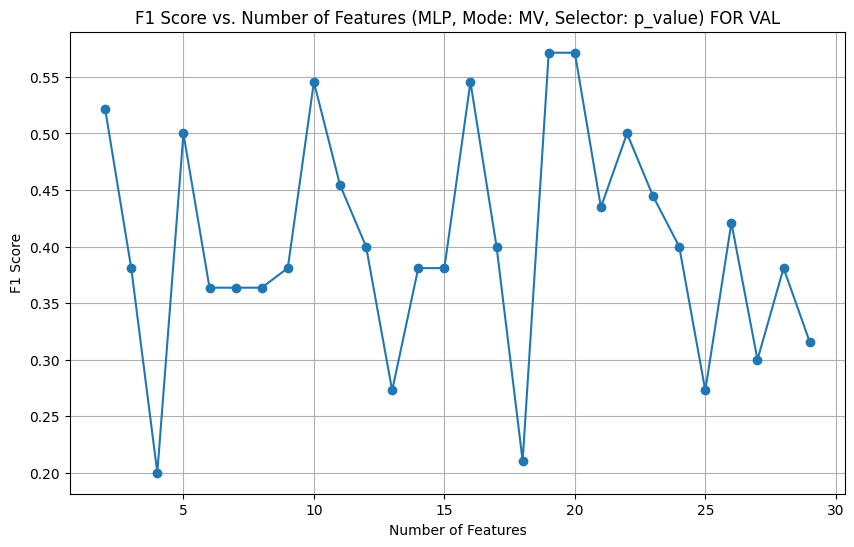

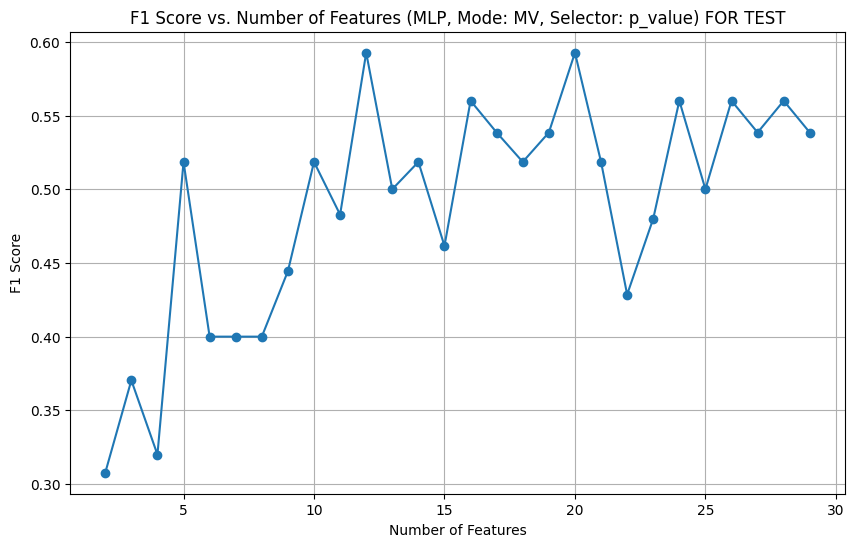

In [93]:

# Filter results_val to focus on 'XgBoost' classifier, 'Mean' mode, and 'mrmr' selector

def get_f1_by_num_features(results_val):
    f1_scores = []
    num_features_list = []
    
    # Loop through the dictionary to find the relevant entries
    for result in results_val:
        if (result['classifier'] == 'XgBoost' and
            result['mode'] == 'MV' and
            result['selector'] == 'mrmr'):
            f1_scores.append(result['f1'])
            if(result['selector']=='lasso'):
                num_features_list.append(result['alpha'])
            else:
                num_features_list.append(result['num_features'])
    
    return num_features_list, f1_scores

# Fetch data (you would pass in your actual results_val dictionary here)
num_features_list, f1_scores = get_f1_by_num_features(results_val)

# Plot F1 score against number of features
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, f1_scores, marker='o')
plt.title("F1 Score vs. Number of Features (MLP, Mode: MV, Selector: p_value) FOR VAL")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

num_features_list, f1_scores = get_f1_by_num_features(results_test)

# Plot F1 score against number of features
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, f1_scores, marker='o')
plt.title("F1 Score vs. Number of Features (MLP, Mode: MV, Selector: p_value) FOR TEST")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


### plotto la ROC nel caso migliore

In [24]:

def classification_method_new(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    if(mode == "Val"):
            selected_features = None 
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded,y_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                    return
                
                features_test = filter_patients_features(features_test, selected_features)
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features) 
        
            smote = SMOTE(random_state=42)
            #adasyn = ADASYN(random_state=42)

            X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            classifier.fit(X_resampled, y_resampled)
   
    if (mode == "Test"): ## non si effettua nuovamente il training e la feature selection
        features_test = filter_patients_features(features_test, selected_features)
        number_features = len(selected_features)

  
    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
        
    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    ## viene calcolata la threshold che porta a un f1 migliore e effettuata la prediction con quella
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore che viene passata dal validation
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)
    fpr, tpr, _ = roc_curve(y_test, patient_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, patient_scores) ## utili per ricostruire grafici
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold, number_features, selected_features, classifier, fpr, tpr




In [34]:
classi = SVC(kernel='rbf', probability=True, random_state=42)

best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc_val, bt, _, selected_features, _, fpr_val, tpr_val= classification_method_new(
                                        'p_value', 0, classi, x_train_expanded, y_train_expanded, 
                                        patients_val, y_val, final_patients_val, 27, 'Mean', thresholds=0.5
                                   )

classi = SVC(kernel='rbf', probability=True, random_state=42)

best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc_test, bt, number_features, selected_features, _, fpr_test, tpr_test = classification_method_new(
                                        'p_value', 0, classi, x_train_expanded1, y_train_expanded1, 
                                        patients_test, y_test, final_patients_test, 27, 'Mean', thresholds=0.5
                                   )



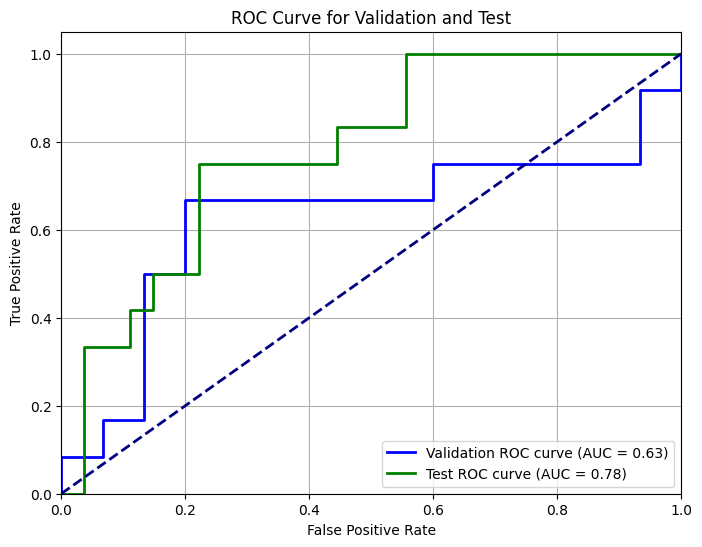

In [35]:


# Assuming you already have the FPR, TPR, and AUC values from both validation and test results

# First plot for Validation ROC curve
def plot_roc_curve(fpr_val, tpr_val, roc_auc_val, fpr_test, tpr_test, roc_auc_test):
    plt.figure(figsize=(8, 6))

    # Plot Validation ROC Curve
    plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f})')
    
    # Plot Test ROC Curve
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
    
    # Plot baseline
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Configure plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Validation and Test')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Example of calling the plot_roc_curve function with validation and test data
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, fpr_test, tpr_test, roc_auc_test)
